Trailed source model from Vereš et al. 2012 method

In [27]:
import numpy as np
from time import time 
from scipy.special import erf

from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [29]:
def trailedModel(x,y,F,L,theta,x0,y0,sigma,b):
    xp = (x-x0)*np.cos(theta) - (y-y0)*np.sin(theta)
    yp = (x-x0)*np.sin(theta) + (y-y0)*np.cos(theta)
    A = F/(L*2)
    B = np.exp(-0.5 * yp**2 / sigma**2)
    C = erf((xp + L/2) / (np.sqrt(2) * sigma))
    D = erf((xp - L/2) / (np.sqrt(2) * sigma))
    return b + A * B * (C - D)

def makeModelImage(params, xdim, ydim, args, noise=False):
    F, L, theta, x0, y0 = params
    b, sigma = args
    
    x = np.arange(-xdim//2 + 1, xdim//2 + 1)
    y = np.arange(-ydim//2 + 1, ydim//2 + 1)
    im = trailedModel(x[None,:],y[:,None],F,L,theta,x0,y0,sigma,b)
    
    if noise: im = np.random.poisson(im)
    
    return im

In [30]:
trailedModel(0,0,1200,5,0,0,0,1.5,0)

217.0606309090489

In [31]:
def gradient(x,y,F,L,theta,x0,y0,sigma):
    # Common terms
    xp = ((x-x0)*np.cos(theta) - (y-y0)*np.sin(theta))
    yp = ((x-x0)*np.sin(theta) + (y-y0)*np.cos(theta))
    A = (0.5*F/L)*np.exp(-0.5*(yp/sigma)**2)
    B = np.exp(-((L + 2*(x-x0)*np.cos(theta) - 2*(y-y0)*np.sin(theta))/sigma)**2 / 8.0)
    C = np.exp(-((L - 2*(x-x0)*np.cos(theta) + 2*(y-y0)*np.sin(theta))/sigma)**2 / 8.0)
    D = erf((xp - 0.5*L)/(sigma*np.sqrt(2)))
    E = erf((xp + 0.5*L)/(sigma*np.sqrt(2)))
    a = np.sqrt(2/np.pi)*sigma
    
    dfdF = trailedModel(x,y,1.0,L,theta,x0,y0,sigma,0.0) # f / F
    dfdL = (A/L)*(L/(np.sqrt(2*np.pi) * sigma)*(B + C) + (D - E))
    dfdtheta = (A/sigma**2)*yp*(a*(C - B) + xp*(D - E))
    dfdx0 = (A/sigma**2)*(a*np.cos(theta)*(C - B) + np.sin(theta)*yp*(E - D))
    dfdy0 = (A/sigma**2)*(a*np.sin(theta)*(B - C) + np.cos(theta)*yp*(E - D))
    
    return np.array([dfdF, dfdL, dfdtheta, dfdx0, dfdy0])

def makeGradientImages(params, xdim, ydim, args):
    F, L, theta, x0, y0 = params
    b, sigma = args
    
    x = np.arange(-xdim//2 + 1, xdim//2 + 1)
    y = np.arange(-ydim//2 + 1, ydim//2 + 1)
    
    ims = gradient(x[None,:],y[:,None],F,L,theta,x0,y0,sigma)
    return ims

In [32]:
F = 1200
L = 5
theta = 0.0
x0 = 1.0; y0 = 1.0
h = 1e-8
params = np.array([F,L,theta,x0,y0])

grad = np.zeros(5)
for i in range(5):
    params[i] += h
    F, L, theta, x0, y0 = params
    p = trailedModel(0,0,F,L,theta,x0,y0,1.5,0.0)    
    params[i] -= 2*h
    F, L, theta, x0, y0 = params
    m = trailedModel(0,0,F,L,theta,x0,y0,1.5,0.0)
    grad[i] = (p - m)/(2*h)
    params[i] += h
    print(grad[i])

0.13316707736521494
-14.78001365740056
-43.3812743949602
-27.641306132863974
-71.02258194890965


In [33]:
[print(g) for g in gradient(0,0,F,L,theta,x0,y0,1.5)];

0.13316734182580484
-14.780013409370799
-43.38127580469084
-27.641306068592282
-71.02258159687005


In [34]:
grad - gradient(0,0,F,L,theta,x0,y0,1.5)

array([-2.64460590e-07, -2.48029760e-07,  1.40973064e-06, -6.42716920e-08,
       -3.52039592e-07])

SNR:  9.358333461169334


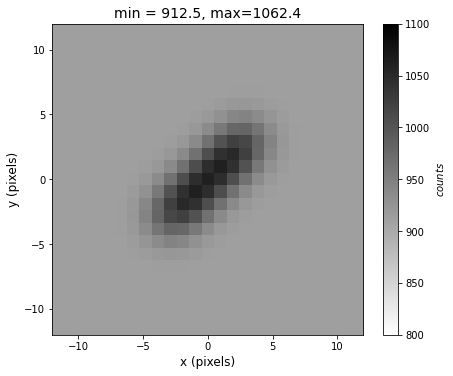

In [35]:
dims = 25
F = 1500.2
sigma = 1.5
L = 10
theta = -np.pi/4 # rotate trail to image frame
x0 = 0.0
y0 = 0.0
b = 912.5
print("SNR: ", F * 0.66 / np.sqrt(b) / (2.335 * sigma))

params = np.array([F,L,theta,x0,y0])
args = np.array([b, sigma])
im = makeModelImage(params, dims, dims, args, noise=False)
plotCutout(im,clim=(800,1100))

Error:  31.77352386155549


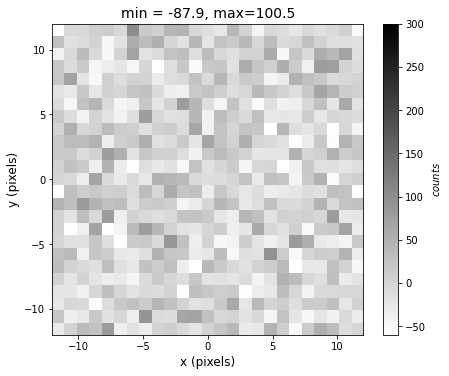

In [36]:
# Calculate noise sigma from diff images
diff_im = makeModelImage(params, dims, dims, args, noise=True) - makeModelImage(params, dims, dims, args, noise=False)
print("Error: ", np.std(diff_im))
plotCutout(diff_im)

In [37]:
def chi_squared(params, data, error, args):
    dims = data.shape
    model = makeModelImage(params, *dims, args)
    error = np.sqrt(model)
    return np.sum(((data - model) / error)**2)

def grad_chi_squared(params, data, error, args):
    N = len(params)
    dims = data.shape
    model = makeModelImage(params, *dims, args)
    dmodel = makeGradientImages(params, *dims, args)
    error = np.sqrt(model)
    res = (data - model) / error
    
    dchi2 = np.zeros(N)
    for i in range(N):
        dchi2[i] = -2.0 * np.dot((dmodel[i] / error).flatten(), res.flatten())
    
    return dchi2

In [38]:
dims = 25
x0 = 1.0
y0 = 2.0
F = 3500.2
sigma = 1.5
L = 8
b = 912.5
theta = np.pi/3

params = np.array([F,L,theta,x0,y0])
args = np.array([b, sigma])

data = makeModelImage(params, dims, dims, args, noise=True)
error = np.sqrt(data)
chi_squared(params, data, error, args) / (data.size - 5 - 1)

0.9214474013026729

In [39]:
dims = 25
F = 3500.2
L = 8
theta = np.pi/3
x0 = 1.0
y0 = 2.0
b = 912.5
sigma = 1.8

params = np.array([F, L, theta, x0, y0])
args = np.array([b, sigma])

In [40]:
%%time
res = minimize(chi_squared, params, args=(data, error, args), method='L-BFGS-B', jac=grad_chi_squared, options={'maxiter':5000})

CPU times: user 72.1 ms, sys: 5.01 ms, total: 77.1 ms
Wall time: 74.8 ms


In [41]:
(res.x - params) / params

array([-0.09582429, -0.04261294, -0.00916101, -0.06427001, -0.03351957])

0.9772650634069654


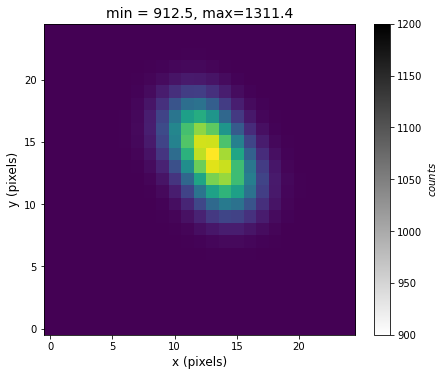

In [42]:
fit_image = makeModelImage(res.x, dims, dims, args, noise=False)
print(res.fun / (fit_image.size - 5 - 1))
plotCutout(fit_image,clim=(900,1200))
plt.imshow(fit_image,origin='lower')

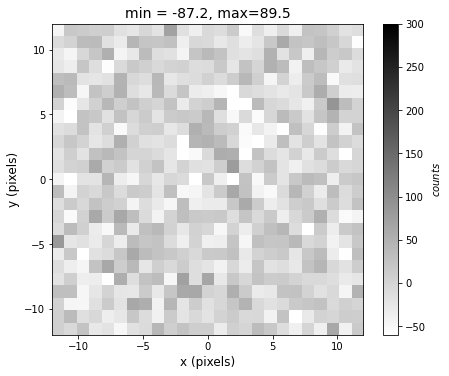

In [43]:
plotCutout(data - fit_image)

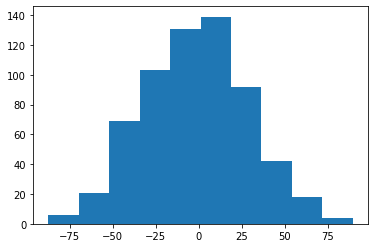

In [44]:
plt.hist((data - fit_image).flatten());

In [45]:
def test_methods(methods, N=25):
    times = np.zeros(len(methods))
    ttmp = np.zeros(N)
    chi2tmp = np.zeros(N)
    values = np.zeros(len(methods))
    for i in range(len(methods)):
        for j in range(N):
            ti = time()
            res = minimize(chi_squared, params, args=(data, error, args), method=methods[i], jac=grad_chi_squared, options={'maxiter':5000})
            tf = time()
            chi2tmp[j] = res.fun
            ttmp[j] = tf - ti
        
        jtmp = np.where(np.min(ttmp))
        times[i] = ttmp[jtmp][0]
        values[i] = chi2tmp[jtmp][0] / (data.size - 5 - 1)
    
    return np.array([methods, times, values])

In [46]:
methods = ['Nelder-Mead','Powell','CG','BFGS',
           'Newton-CG','L-BFGS-B','TNC','COBYLA',
           'SLSQP','trust-constr']
m, t, v = test_methods(methods)

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  RuntimeWarning)


In [47]:
[print(t[i],'\t: ', v[i], '\t: ', m[i]) for i in range(len(methods))];

0.1296827793121338 	:  0.9772309716761646 	:  Nelder-Mead
0.017421722412109375 	:  0.9772317671303785 	:  Powell
0.03892874717712402 	:  1.013415132494766 	:  CG
0.014825105667114258 	:  0.9772779752444776 	:  BFGS
0.10379672050476074 	:  0.9772362898794769 	:  Newton-CG
0.029120922088623047 	:  0.9772650634069654 	:  L-BFGS-B
0.020812034606933594 	:  0.9772772638169092 	:  TNC
0.04727792739868164 	:  1.0133806434345753 	:  COBYLA
0.012526512145996094 	:  0.9772770318168987 	:  SLSQP
0.15305685997009277 	:  1.0134178583732416 	:  trust-constr
